In [1]:
import torch
from torch import optim
from torch.optim.lr_scheduler import StepLR

from torch.utils.data import DataLoader, TensorDataset

from captum.attr import visualization as viz

import numpy as np
import scipy
from scipy.linalg import orth

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd

from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import random

from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature

# our own imports
import util
from util import compute_tangent_space, project_into_tangent_space, normalize_image, dcn

from models import lenet_model_and_optimizer

from MNIST32 import MNIST32, MNIST256

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [9]:
from util import plot_saliency, plot_normalized_saliency, plot_saliency_with_image_contour, visualize

## Load the trained model, test data and feature attributions

In [2]:
z_monitor, x_monitor, c_monitor, t_monitor = pkl.load(open('./output/mnist_monitor_32_10000.pkl', 'rb'))
testset = torch.utils.data.TensorDataset(x_monitor, c_monitor)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

In [3]:
def model_and_optimizer():
    return lenet_model_and_optimizer(lr=1e-3)

model, _ = model_and_optimizer()
model.load_state_dict(torch.load('./models/mnist32_lenet.pth'))
#model.load_state_dict(torch.load("./models/mnist_32_adv_robust_l2.pt"))
model.to(device)
model.eval()
util.test(model, testloader, device)

Test Error:  0.0103


0.0103

In [4]:
inputs = [x_monitor[i, :, :, :] for i in range(len(t_monitor))]
grad_list, int_grad_list, igx_list, smooth_grad_list = torch.load('./output/mnist32_feature_attributions.pkl')

In [5]:
random_vectors_list = [np.random.normal(size = grad_list[0].shape) for _ in range(len(t_monitor))]

In [6]:
frac_random_its = util.tangent_space_ratio(random_vectors_list, t_monitor)
frac_grad_its = util.tangent_space_ratio(grad_list, t_monitor)
frac_smooth_grad_its = util.tangent_space_ratio(smooth_grad_list, t_monitor)
frac_int_grad_its = util.tangent_space_ratio(int_grad_list, t_monitor) 
frac_ixg_its = util.tangent_space_ratio(igx_list, t_monitor)

In [7]:
predictions = []
for x in tqdm(x_monitor):
    img = dcn(x)
    pred = model(torch.tensor(img).unsqueeze(0).cuda()).argmax().item()
    predictions.append(pred)
predictions = torch.tensor(predictions)

100%|██████████| 10000/10000 [00:04<00:00, 2382.57it/s]


### MNIST Task 1

In [38]:
# correct predictions with large fraction in tangent space
class_max_indices = []
for c in range(10):
    class_indices = np.where(c_monitor == c)[0]           # indices where the true class is c
    class_quantile = np.quantile(np.array(frac_grad_its)[class_indices], 0.9)
    pred_indices = np.where(predictions == c)[0]          # indices where we predicted class c
    indices = np.where(np.array(frac_grad_its) > class_quantile)[0] # where the fraction in tangent space is additionally larger than the class-quantile
    indices = list(set(indices).intersection(class_indices))
    indices = list(set(indices).intersection(pred_indices))  # indices where we correctly predicted class c
    indices = np.random.choice(indices, size=10, replace=True if len(t_monitor) < 5000 else False)
    
    for i in range(10):
        img = inputs[indices[i]]
        grad = grad_list[indices[i]]
        tangent_space = t_monitor[indices[i]]
        
        # tangent space decomposition
        grad_in_tangent_space = util.project_into_tangent_space(tangent_space, grad)
        grad_not_in_tangnet_space = grad-grad_in_tangent_space
        pred = model(img.unsqueeze(0).cuda()).argmax().item()
        ratio = np.linalg.norm(grad_in_tangent_space.flatten())/np.linalg.norm(grad.flatten())

        # normalize vectors
        grad = grad / np.linalg.norm(grad.flatten())
        grad_in_tangent_space = grad_in_tangent_space / np.linalg.norm(grad_in_tangent_space.flatten())
        grad_not_in_tangnet_space = grad_not_in_tangnet_space / np.linalg.norm(grad_not_in_tangnet_space.flatten())
        
        # clip the p-percent larget values off
        pooled_vectors = np.array((grad, grad_in_tangent_space, grad_not_in_tangnet_space)).flatten().squeeze()
        quantile = np.quantile(abs(pooled_vectors), 1-0.005)
        
        grad[np.where(grad > quantile)] = quantile
        grad[np.where(grad < -quantile)] = -quantile
        grad_in_tangent_space[np.where(grad_in_tangent_space > quantile)] = quantile
        grad_in_tangent_space[np.where(grad_in_tangent_space < -quantile)] = -quantile
        grad_not_in_tangnet_space[np.where(grad_not_in_tangnet_space > quantile)] = quantile
        grad_not_in_tangnet_space[np.where(grad_not_in_tangnet_space < -quantile)] = -quantile
        
        # common color space
        v = max([max(abs(x.min()), x.max()) for x in [grad, grad_in_tangent_space, grad_not_in_tangnet_space]])
    
        # img in tangent spac
        fig, axs = plt.subplots(figsize=(6, 6))   
        plot_saliency(axs, grad_in_tangent_space, -v, v, savefig=f'./output/experiment/mnist0/class{c}_img{i}_tagent.png')
        plt.close('all')
        
        # img not in tangent space
        fig, axs = plt.subplots(figsize=(6, 6))   
        plot_saliency(axs, grad_not_in_tangnet_space, -v, v, savefig=f'./output/experiment/mnist0/class{c}_img{i}_not_tagent.png')        
        plt.close('all')

### For the human experiment: a reference image of random noise

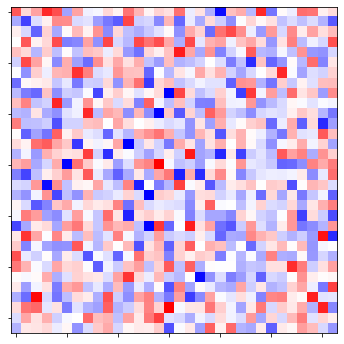

In [59]:
np.random.seed(0)
random_vector = np.random.normal(size = grad_list[0].shape)

# normalize vector
random_vector = random_vector / np.linalg.norm(random_vector.flatten())

# clip the p-percent larget values off
quantile = np.quantile(abs(random_vector.flatten()), 1-0.005)
random_vector[np.where(random_vector > quantile)] = quantile
random_vector[np.where(random_vector < -quantile)] = -quantile
    
# color space
v = max(abs(random_vector.min()), random_vector.max())

fig, axs = plt.subplots(figsize=(6, 6))   
plot_saliency(axs, random_vector, -v, v, savefig=f'./output/experiment/random_vector.png')    
plt.show()
plt.close('all')

### For the human experiment: some simple structures

In [24]:
import matplotlib

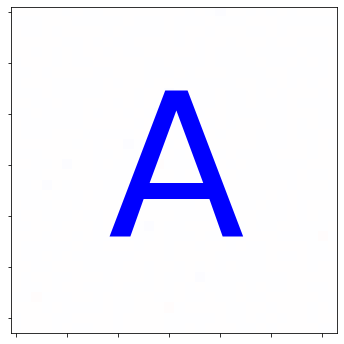

In [60]:
np.random.seed(0)
cmap = matplotlib.cm.get_cmap('bwr')

random_vector = np.random.normal(size = grad_list[0].shape)

# normalize vector
random_vector = random_vector / np.linalg.norm(random_vector.flatten())

# clip the p-percent larget values off
quantile = np.quantile(abs(random_vector.flatten()), 1-0.005)
random_vector[np.where(random_vector > quantile)] = quantile
random_vector[np.where(random_vector < -quantile)] = -quantile
    
# color space
v = max(abs(random_vector.min()), random_vector.max())+10

fig, axs = plt.subplots(figsize=(6, 6))   
plot_saliency(axs, random_vector, -v, v)    
matplotlib.pyplot.text(x=9, y=22, s='A', size=200, c=cmap(-1))
plt.savefig(f'./output/experiment/structured_image.png')
plt.show()

## MNIST Task 1: Compare different attributions for the same image

In [29]:
A_fraction = 0 # collect summary statistics
B_fraction = 0

for i in range(100):
    sns.set_style('white')
    fractions = [frac_grad_its[i], frac_int_grad_its[i], frac_ixg_its[i]]
    ordering = np.argsort(fractions)
    
    fig, axs = plt.subplots(figsize=(6, 6))   
    plot_normalized_saliency(axs, grad_list[i], savefig=f'./output/experiment/mnist1/instance{i}_order{ordering[0]}.png')
    plt.title(f'instance{i}_order{ordering[0]}: {fractions[0]:.3f}')
    #plt.show()
    plt.close()
    
    fig, axs = plt.subplots(figsize=(6, 6))   
    plot_normalized_saliency(axs, int_grad_list[i], savefig=f'./output/experiment/mnist1/instance{i}_order{ordering[1]}.png')
    plt.title(f'instance{i}_order{ordering[1]}: {fractions[1]:.3f}')
    #plt.show()
    plt.close()
    
    fig, axs = plt.subplots(figsize=(6, 6))   
    plot_normalized_saliency(axs, igx_list[i], savefig=f'./output/experiment/mnist1/instance{i}_order{ordering[2]}.png')
    plt.title(f'instance{i}_order{ordering[2]}: {fractions[2]:.3f}')
    #plt.show()
    plt.close()
    
    sorted_fractions = np.sort(fractions)
    A_fraction = A_fraction + sorted_fractions[0] + sorted_fractions[1]
    B_fraction = B_fraction + sorted_fractions[1] + sorted_fractions[2]
    
print('Mean of group A', A_fraction / 200)
print('Mean of group B', B_fraction / 200)

Mean of group A 0.32042871417837093
Mean of group B 0.37576198710152264
